# HW 5: Seq2seq with Attention


*   본 실습에서는 sequence to sequence 모델을 구현하고 attention 모듈을 추가합니다.


### Part 1. Seq2seq with toy example

**Part 1.1 데이터 전처리**

In [1]:
from tqdm import tqdm
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.nn import functional as F

import torch
import random

`src_data`를 `trg_data`로 바꾸는 번역 task를 수행하기 위한 sample data를 준비합니다.

전체 단어 수는 100 개이고 다음과 같이 `pad token`, `start token`, `end token`의 id도 정의합니다.

In [2]:
vocab_size = 100
pad_id = 0
sos_id = 1 # <sos> : start of sentence
eos_id = 2 # <eos> : end of sentnece

src_data = [
  [3, 77, 56, 26, 3, 55, 12, 36, 31],
  [58, 20, 65, 46, 26, 10, 76, 44],
  [58, 17, 8],
  [59],
  [29, 3, 52, 74, 73, 51, 39, 75, 19],
  [41, 55, 77, 21, 52, 92, 97, 69, 54, 14, 93],
  [39, 47, 96, 68, 55, 16, 90, 45, 89, 84, 19, 22, 32, 99, 5],
  [75, 34, 17, 3, 86, 88],
  [63, 39, 5, 35, 67, 56, 68, 89, 55, 66],
  [12, 40, 69, 39, 49]
]

trg_data = [
  [75, 13, 22, 77, 89, 21, 13, 86, 95],
  [79, 14, 91, 41, 32, 79, 88, 34, 8, 68, 32, 77, 58, 7, 9, 87],
  [85, 8, 50, 30],
  [47, 30],
  [8, 85, 87, 77, 47, 21, 23, 98, 83, 4, 47, 97, 40, 43, 70, 8, 65, 71, 69, 88],
  [32, 37, 31, 77, 38, 93, 45, 74, 47, 54, 31, 18],
  [37, 14, 49, 24, 93, 37, 54, 51, 39, 84],
  [16, 98, 68, 57, 55, 46, 66, 85, 18],
  [20, 70, 14, 6, 58, 90, 30, 17, 91, 18, 90],
  [37, 93, 98, 13, 45, 28, 89, 72, 70]
]

In [8]:
# target data 의 각 문장의 시작과 끝에 <sos> token id 와 <eos> token id 를 추가합니다.
trg_data = [[sos_id]+seq+[eos_id] for seq in tqdm(trg_data)]

100%|██████████| 10/10 [00:00<00:00, 72691.58it/s]


In [15]:
# 각 문장의 길이를 동일하게 맞춰주기 위해 <pad> token id 를 추가하는 padding 함수를 정의합니다.
def padding(data):
  max_len = len(max(data, key=len))
  print(f"Maximum sequence length: {max_len}")

  valid_lens = []
  for i, seq in enumerate(tqdm(data)):
    valid_lens.append(len(seq))
    if len(seq) < max_len:
      data[i] = seq + [pad_id] * (max_len - len(seq))

  return data, valid_lens, max_len

In [16]:
src_data, src_lens, src_max_len = padding(src_data)
trg_data, trg_lens, trg_max_len = padding(trg_data)

Maximum sequence length: 15


100%|██████████| 10/10 [00:00<00:00, 53025.34it/s]


Maximum sequence length: 22


100%|██████████| 10/10 [00:00<00:00, 71453.22it/s]


In [19]:
# B: batch size, 
# S_L: source maximum sequence length, 
# T_L: target maximum sequence length

src_batch = torch.LongTensor(src_data)  # (B, S_L)
src_batch_lens = torch.LongTensor(src_lens)  # (B)
trg_batch = torch.LongTensor(trg_data)  # (B, T_L)
trg_batch_lens = torch.LongTensor(trg_lens)  # (B)

print(src_batch.shape)
print(src_batch_lens.shape)
print(trg_batch.shape)
print(trg_batch_lens.shape)

torch.Size([10, 15])
torch.Size([10])
torch.Size([10, 22])
torch.Size([10])


In [21]:
src_batch_lens, sorted_idx = src_batch_lens.sort(descending=True)
src_batch = src_batch[sorted_idx]
trg_batch = trg_batch[sorted_idx]
trg_batch_lens = trg_batch_lens[sorted_idx]

print(src_batch)
print(src_batch_lens)
print(trg_batch)
print(trg_batch_lens)

tensor([[ 3, 77, 56, 26,  3, 55, 12, 36, 31,  0,  0,  0,  0,  0,  0],
        [58, 20, 65, 46, 26, 10, 76, 44,  0,  0,  0,  0,  0,  0,  0],
        [58, 17,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [59,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [29,  3, 52, 74, 73, 51, 39, 75, 19,  0,  0,  0,  0,  0,  0],
        [41, 55, 77, 21, 52, 92, 97, 69, 54, 14, 93,  0,  0,  0,  0],
        [39, 47, 96, 68, 55, 16, 90, 45, 89, 84, 19, 22, 32, 99,  5],
        [75, 34, 17,  3, 86, 88,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [63, 39,  5, 35, 67, 56, 68, 89, 55, 66,  0,  0,  0,  0,  0],
        [12, 40, 69, 39, 49,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])
tensor([15, 15, 15, 15, 15, 15, 15, 15, 15, 15])
tensor([[ 1, 75, 13, 22, 77, 89, 21, 13, 86, 95,  2,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0],
        [ 1, 79, 14, 91, 41, 32, 79, 88, 34,  8, 68, 32, 77, 58,  7,  9, 87,  2,
          0,  0,  0,  0],
        [ 1, 85,  8, 50, 30,  2,  0,

In [22]:
sorted_idx

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

**Part 1.2 Encoder 구현**


*   Embedding layer, output layer, GRU cell 을 포함한 encoder 모듈을 구현합니다.



In [23]:
embedding_size = 256
hidden_size = 512
num_layers = 2
num_dirs = 2 # 2 if bidirectional=True otherwise 1
dropout = 0.1

In [24]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()

    self.embedding = nn.Embedding(vocab_size, embedding_size)
    self.gru = nn.GRU(
        input_size=embedding_size, 
        hidden_size=hidden_size,
        num_layers=num_layers,
        bidirectional=True if num_dirs > 1 else False,
        dropout=dropout
    )
    self.linear = nn.Linear(num_dirs * hidden_size, hidden_size)

  def forward(self, batch, batch_lens):  # batch: (B, S_L), batch_lens: (B)
    # d_w: word embedding size
    batch_emb = self.embedding(batch)  # (B, S_L, d_w)
    batch_emb = batch_emb.transpose(0, 1)  # (S_L, B, d_w)

    packed_input = pack_padded_sequence(batch_emb, batch_lens)

    h_0 = torch.zeros((num_layers * num_dirs, batch.shape[0], hidden_size))  # (num_dirs*num_layers, B, d_h) = (4, B, d_h)
    packed_outputs, h_n = self.gru(packed_input, h_0)  # h_n: (4, B, d_h)
    outputs = pad_packed_sequence(packed_outputs)[0]  # outputs: (S_L, B, 2d_h)
    outputs = torch.tanh(self.linear(outputs))  # (S_L, B, d_h)

    forward_hidden = h_n[-2, :, :]
    backward_hidden = h_n[-1, :, :]
    hidden = torch.tanh(self.linear(torch.cat((forward_hidden, backward_hidden), dim=-1))).unsqueeze(0)  # (1, B, d_h)

    return outputs, hidden

In [25]:
encoder = Encoder()

### **Dot-product Attention 구현**
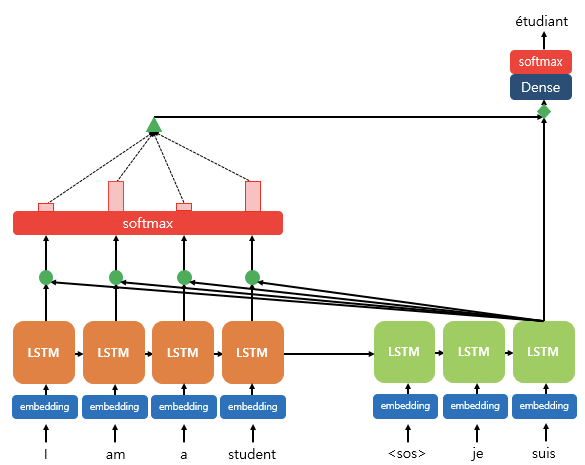

[Dot-product Attention 계산 메커니즘 복습하기](https://wikidocs.net/22893)

우선 대표적인 attention 형태 중 하나인 Dot-product Attention은 다음과 같이 구현할 수 있습니다.



In [26]:
class DotAttention(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, decoder_hidden, encoder_outputs):  # (1, B, d_h), (S_L, B, d_h)
    query = decoder_hidden.squeeze(0)  # (B, d_h)
    key = encoder_outputs.transpose(0, 1)  # (B, S_L, d_h)

    energy = torch.sum(torch.mul(key, query.unsqueeze(1)), dim=-1)  # (B, S_L)

    attn_scores = F.softmax(energy, dim=-1)  # (B, S_L)
    attn_values = torch.sum(torch.mul(encoder_outputs.transpose(0, 1), attn_scores.unsqueeze(2)), dim=1)  # (B, d_h)

    return attn_values, attn_scores

In [27]:
dot_attn = DotAttention()

이제 이 attention 모듈을 가지는 Decoder 클래스를 구현하겠습니다.

In [28]:
class Decoder(nn.Module):
  def __init__(self, attention):
    super().__init__()

    self.embedding = nn.Embedding(vocab_size, embedding_size)
    self.attention = attention
    self.rnn = nn.GRU(
        embedding_size,
        hidden_size
    )
    self.output_linear = nn.Linear(2*hidden_size, vocab_size)

  def forward(self, batch, encoder_outputs, hidden):  # batch: (B), encoder_outputs: (L, B, d_h), hidden: (1, B, d_h)  
    batch_emb = self.embedding(batch)  # (B, d_w)
    batch_emb = batch_emb.unsqueeze(0)  # (1, B, d_w)

    outputs, hidden = self.rnn(batch_emb, hidden)  # (1, B, d_h), (1, B, d_h)

    attn_values, attn_scores = self.attention(hidden, encoder_outputs)  # (B, d_h), (B, S_L)
    concat_outputs = torch.cat((outputs, attn_values.unsqueeze(0)), dim=-1)  # (1, B, 2d_h)

    return self.output_linear(concat_outputs).squeeze(0), hidden  # (B, V), (1, B, d_h)

In [29]:
decoder = Decoder(dot_attn)

### **Seq2seq 모델 구축**

최종적으로 seq2seq 모델을 다음과 같이 구성할 수 있습니다.

In [30]:
class Seq2seq(nn.Module):
  def __init__(self, encoder, decoder):
    super(Seq2seq, self).__init__()

    self.encoder = encoder
    self.decoder = decoder

  def forward(self, src_batch, src_batch_lens, trg_batch, teacher_forcing_prob=0.5):
    # src_batch: (B, S_L), src_batch_lens: (B), trg_batch: (B, T_L)

    encoder_outputs, hidden = self.encoder(src_batch, src_batch_lens)  # encoder_outputs: (S_L, B, d_h), hidden: (1, B, d_h)

    input_ids = trg_batch[:, 0]  # (B)
    batch_size = src_batch.shape[0]
    outputs = torch.zeros(trg_max_len, batch_size, vocab_size)  # (T_L, B, V)

    for t in range(1, trg_max_len):
      decoder_outputs, hidden = self.decoder(input_ids, encoder_outputs, hidden)  # decoder_outputs: (B, V), hidden: (1, B, d_h)

      outputs[t] = decoder_outputs
      _, top_ids = torch.max(decoder_outputs, dim=-1)  # top_ids: (B)

      input_ids = trg_batch[:, t] if random.random() > teacher_forcing_prob else top_ids

    return outputs

In [31]:
seq2seq = Seq2seq(encoder, decoder)

### **모델 사용해보기**

만든 모델로 결과를 확인해보겠습니다.

In [32]:
# V: vocab size
outputs = seq2seq(src_batch, src_batch_lens, trg_batch)  # (T_L, B, V)

print(outputs)
print(outputs.shape)

tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0239, -0.0514, -0.0691,  ...,  0.0661, -0.2162,  0.0218],
         [ 0.0551, -0.0690, -0.0949,  ...,  0.0495, -0.2155,  0.0042],
         [ 0.0351, -0.0674, -0.1248,  ...,  0.0690, -0.1953,  0.0205],
         ...,
         [ 0.0586, -0.0362, -0.1084,  ...,  0.0779, -0.1948,  0.0173],
         [ 0.0505, -0.0295, -0.1277,  ...,  0.0436, -0.2339,  0.0068],
         [ 0.0346, -0.0811, -0.1252,  ...,  0.0837, -0.2036,  0.0442]],

        [[ 0.0136, -0.0342, -0.1185,  ..., -0.0040, -0.1362,  0.1779],
         [-0.0165,  0.0576, -0.0034,  ...,  0

In [33]:
sample_sent = [4, 10, 88, 46, 72, 34, 14, 51]
sample_len = len(sample_sent)

sample_batch = torch.LongTensor(sample_sent).unsqueeze(0)  # (1, L)
sample_batch_len = torch.LongTensor([sample_len])  # (1)

encoder_output, hidden = seq2seq.encoder(sample_batch, sample_batch_len)  # hidden: (4, 1, d_h)

In [34]:
input_id = torch.LongTensor([sos_id]) # (1)
output = []

for t in range(1, trg_max_len):
  decoder_output, hidden = seq2seq.decoder(input_id, encoder_output, hidden)  # decoder_output: (1, V), hidden: (4, 1, d_h)

  _, top_id = torch.max(decoder_output, dim=-1)  # top_ids: (1)

  if top_id == eos_id:
    break
  else:
    output += top_id.tolist()
    input_id = top_id

In [35]:
output

[64,
 79,
 79,
 92,
 92,
 79,
 92,
 92,
 79,
 92,
 92,
 79,
 49,
 79,
 92,
 92,
 79,
 92,
 92,
 79,
 92]

### **Concat Attention 구현**

Bahdanau Attention이라고도 불리는 Concat Attention을 구현해보도록 하겠습니다.  


*   `self.w`: Concat한 query와 key 벡터를 1차적으로 linear transformation.
*   `self.v`: Attention logit 값을 계산.



In [36]:
class ConcatAttention(nn.Module):
  def __init__(self):
    super().__init__()

    self.w = nn.Linear(2*hidden_size, hidden_size, bias=False)
    self.v = nn.Linear(hidden_size, 1, bias=False)

  def forward(self, decoder_hidden, encoder_outputs):  # (1, B, d_h), (S_L, B, d_h)
    src_max_len = encoder_outputs.shape[0]

    decoder_hidden = decoder_hidden.transpose(0, 1).repeat(1, src_max_len, 1)  # (B, S_L, d_h)
    encoder_outputs = encoder_outputs.transpose(0, 1)  # (B, S_L, d_h)

    concat_hiddens = torch.cat((decoder_hidden, encoder_outputs), dim=2)  # (B, S_L, 2d_h)
    energy = torch.tanh(self.w(concat_hiddens))  # (B, S_L, d_h)

    attn_scores = F.softmax(self.v(energy), dim=1)  # (B, S_L, 1)
    attn_values = torch.sum(torch.mul(encoder_outputs, attn_scores), dim=1)  # (B, d_h)

    return attn_values, attn_scores

In [37]:
concat_attn = ConcatAttention()

마찬가지로 decoder를 마저 구현하겠습니다.

In [39]:
class Decoder(nn.Module):
  def __init__(self, attention):
    super().__init__()

    self.embedding = nn.Embedding(vocab_size, embedding_size)
    self.attention = attention
    self.rnn = nn.GRU(
        embedding_size + hidden_size,
        hidden_size
    )
    self.output_linear = nn.Linear(hidden_size, vocab_size)

  def forward(self, batch, encoder_outputs, hidden):  # batch: (B), encoder_outputs: (S_L, B, d_h), hidden: (1, B, d_h)  
    batch_emb = self.embedding(batch)  # (B, d_w)
    batch_emb = batch_emb.unsqueeze(0)  # (1, B, d_w)

    attn_values, attn_scores = self.attention(hidden, encoder_outputs)  # (B, d_h), (B, S_L)

    concat_emb = torch.cat((batch_emb, attn_values.unsqueeze(0)), dim=-1)  # (1, B, d_w+d_h)

    outputs, hidden = self.rnn(concat_emb, hidden)  # (1, B, d_h), (1, B, d_h)

    return self.output_linear(outputs).squeeze(0), hidden  # (B, V), (1, B, d_h)

In [40]:
decoder = Decoder(concat_attn)

In [41]:
seq2seq = Seq2seq(encoder, decoder)

In [42]:
outputs = seq2seq(src_batch, src_batch_lens, trg_batch)

print(outputs)
print(outputs.shape)

tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0913, -0.0484,  0.0784,  ..., -0.2377,  0.0674, -0.0338],
         [ 0.0726, -0.0645,  0.0766,  ..., -0.2495,  0.0252, -0.0103],
         [ 0.1109, -0.0693,  0.1253,  ..., -0.2850,  0.0191, -0.0183],
         ...,
         [ 0.0983, -0.0660,  0.1198,  ..., -0.2693, -0.0060, -0.0271],
         [ 0.0930, -0.0466,  0.0676,  ..., -0.2798,  0.0032, -0.0331],
         [ 0.0891, -0.0938,  0.0832,  ..., -0.2571,  0.0366, -0.0496]],

        [[ 0.3017,  0.0130,  0.0746,  ..., -0.1872,  0.1010,  0.2698],
         [-0.0279, -0.1289,  0.1903,  ..., -0